In [1]:
import os
import time
import itertools

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay


from scipy.fftpack import fftn, fftshift
from scipy import signal, special
from skimage.filters import window
import pywt

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
import seaborn as sns
from PIL import Image
import tqdm.notebook as tqdm
from IPython import display
import gc 

%matplotlib inline

%load_ext autoreload

from data_loaders import *
%autoreload 2
from training_utils import *
%autoreload 2
from cnn_model import *
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2D1B8D5C-7891-3680-9CF9-F771AE880676> /Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <D9949A91-AC47-3F4B-804D-0B66B93A7A59> /Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints a

# Load training data

In [2]:
# Creating the datasets
mean = [7.4, 0, 0]
std = [5.5, 60, 75]

mean = [7.4, 7.4]
std = [5.5, 5.5]

transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=mean, std=std),
    v2.ToDtype(torch.float),
])


train_labeled_data = CloudDetectionTrain(
    transform=transform
)

test_labeled_data = CloudDetectionTrain(
    target_transform=transform
)

# scl = 10
# batch_id = 19  # Cloudy data, not in training set
# transform = v2.Compose([
#     v2.ToTensor(),
#     v2.Normalize(mean=[0], std=[100*scl]),
#     v2.ToDtype(torch.float, scale=True),
#     # v2.ColorJitter(0.5, None, None, None),
#     # v2.GaussianBlur(kernel_size=(5, 5), sigma=(0.2, 0.5))
# ])

# inference_data = CloudDetectionInference(
#     batch_id = batch_id,
#     transform = transform
# )

In [3]:
def apply_fft(data, shape=(64, 64)):
    if data is None or not isinstance(data, np.ndarray):
        print('no image')
        return None
    window_type = "hann"
    data = data * window(window_type, data.shape)
    data = np.abs(fftn(data, shape))
    data = fftshift(data)
    data = np.log(data)
    return data

def apply_wavelet(data, wavelet='db1', level=10):
    if data is None or not isinstance(data, np.ndarray):
        print('no image')
        return None
    coeffs = pywt.wavedec2(data, wavelet=wavelet, mode='symmetric', level=level)
    arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    return arr

# plt.figure(figsize=(8,8))
# ax = plt.gca()

# data = apply_fft(train_labeled_data[np.random.randint(0, len(train_labeled_data))][0].numpy())
# im_fft = ax.imshow(
#     data, vmin=2.5, vmax=7, cmap='mako'
# )
# plt.colorbar(
#     im_fft, label='$\log|X[k, \ell]|$', fraction=0.04, location='bottom', ax=ax
# )
# ax.axis('off')

# Visualize data
The features are 2D FFT of -60s difference images between 6ms-integrated PANOSETI pmaging data

In [5]:
raw_data = train_labeled_data[np.random.randint(0, len(train_labeled_data))][0].numpy()

coeffs = pywt.wavedec2(data=raw_data.squeeze(), wavelet='db1', mode='symmetric', level=5)
arr, coeff_slices = pywt.coeffs_to_array(coeffs)
# coeffs
plt.figure(figsize=(10,10))
plt.matshow(arr)

ValueError: coeffs corresponds to a DWT performed over only a subset of the axes.  In this case, axes must be specified.

In [4]:
def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=5, alpha=0.8, cmap='crest')
    ax.set_title(title)
    ax.legend()
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(10, 10), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()

def circularLowpassKernel(omega_c, N):  # omega = cutoff frequency in radians (pi is max), N = horizontal size of the kernel, also its vertical size.
  with np.errstate(divide='ignore',invalid='ignore'):
    kernel = np.fromfunction(lambda x, y: omega_c*special.j1(omega_c*np.sqrt((x - (N - 1)/2)**2 + (y - (N - 1)/2)**2))/(2*np.pi*np.sqrt((x - (N - 1)/2)**2 + (y - (N - 1)/2)**2)), [N, N])
  if N % 2:
    kernel[(N - 1)//2, (N - 1)//2] = omega_c**2/(4*np.pi)
  return kernel


# kernelN = 11  # Horizontal size of the kernel, also its vertical size.
# omega_c = np.pi  # Cutoff frequency in radians <= pi
# kernel = circularLowpassKernel(omega_c, kernelN)
# # plt.imshow(kernel, vmin=-1, vmax=1, cmap='bwr')
# # plt.colorbar()
# # plt.show()


def preview_frames(dataset, class_filter=None, fft_shape=(32,32), wavelet='bior3.7', wavelet_level=5, nframes=100, frame_time=0.01):
    try:
        if class_filter not in [None, 0, 1]:
            raise ValueError(f'class_filter must be 0 (clear) or 1 (cloudy)')
        MAX_ITERS = 1e2
        i = 0
        while i < nframes and i < MAX_ITERS:
            deriv_img, y = dataset[np.random.randint(0, len(dataset))]
            if class_filter is not None and class_filter != y:
                continue
            else:
                i += 1
            
            kernelN = 11  # Horizontal size of the kernel, also its vertical size.
            omega_c = np.pi * (3/4)  # Cutoff frequency in radians <= pi
            kernel = circularLowpassKernel(omega_c, kernelN)
            # deriv_data = signal.convolve2d(deriv_data, kernel, mode='full')
            
            deriv_data = deriv_img.numpy().squeeze()
            # deriv_data = signal.convolve2d(deriv_data, kernel, mode='full')
            fft_data = apply_fft(deriv_data, shape=fft_shape)
            wavelet_data = apply_wavelet(deriv_data, wavelet=wavelet, level=wavelet_level)


            fig, axs = plt.subplots(1, 3, figsize=(18, 6))

            # -60s derivative image
            ax = axs[0]
            ax.set_title(f'-60s Derivative')
            ax.axis('off')
            im_deriv = ax.imshow(deriv_data, vmin=-125, vmax=125, cmap='icefire')
            fig.colorbar(im_deriv, label=r'$\Delta$ Counts', fraction=0.05, location='bottom', ax=ax, pad=0.02)

            # FFT image
            ax = axs[1]
            ax.axis('off')
            ax.set_title(f'2D FFT of -60s Derivative')
            im_fft = ax.imshow(fft_data, vmin=2.5, vmax=7, cmap='mako')
            plt.colorbar(im_fft, label='$\log|X[k, \ell]|$', fraction=0.05, location='bottom', ax=ax,pad=0.02)

            # Wavelet image
            ax = axs[2]
            ax.set_title(f'{wavelet_level}-level 2D Wavelet of -60s Derivative')
            ax.axis('off')
            im_wavelet = ax.imshow(wavelet_data, vmin=-125*2, vmax=125*2, cmap='icefire')
            plt.colorbar(im_wavelet, label='Coeff Magnitude', fraction=0.05, location='bottom', ax=ax, pad=0.02)
            
            plt.suptitle(f'{"Cloudy" if y else "Clear"}')

            
            
            display.clear_output(wait=True)
            plt.show()
            print(f'Data dimensions: deriv_data.shape={deriv_data.shape}, fft_data.shape={fft_data.shape}, wavelet_data.shape={wavelet_data.shape}')

            time.sleep(frame_time)
            plt.close()
    except KeyboardInterrupt:
        plt.close()
    finally:
        plt.close()
        gc.collect()

In [7]:
print(pywt.wavelist(kind='discrete'))

['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'haar', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20']


In [5]:
# preview_frames(
#     train_labeled_data,
#     class_filter = 0,
#     fft_shape=(64, 64),
#     wavelet='haar',
#     wavelet_level = 1, 
#     nframes = 20,
#     frame_time = 0.01
# )

In [6]:
def scale_data(data):
    with np.errstate(divide='ignore'):
        div = 1 / (np.abs(data)) ** 0.5
        div = np.nan_to_num(div, nan=1)
        scaled_data = data * div
    return scaled_data

def transform_labeled_data(dataset, fft_shape, wavelet, wavelet_level):
    def get_features(x):
        deriv_fft_data = x[0].numpy().squeeze()
        orig_fft_data = x[1].numpy().squeeze()
        # kernelN = 3 # Horizontal size of the kernel, also its vertical size.
        # omega_c = np.pi * (3/4)  # Cutoff frequency in radians <= pi
        # kernel = circularLowpassKernel(omega_c, kernelN)
        # deriv_data = signal.convolve2d(deriv_data, kernel, mode='full')
        
        # fft_data = apply_fft(deriv_data, shape=fft_shape)
        # wavelet_data = apply_wavelet(deriv_data, wavelet=wavelet, level=wavelet_level)
        
        return np.concatenate((
            deriv_fft_data.ravel(),
            orig_fft_data.ravel(),
            # fft_data.ravel(),
            # wavelet_data.ravel(),
        ))
    
    n = len(dataset)
    d = len(get_features(dataset[0][0]))
    print(f'Design matrix dimensions: {n} x {d}')

    
    X = np.zeros((n, d))
    Y = np.zeros(n)
    for i in range(0, n):
        if (i + 1) % 100 == 0 or i == n-1:
            print(f'Progress: {100 * (i+1) / n:.2f}% ({i + 1} / {n})', end = '\r')
        X[i] = get_features(dataset[i][0])
        Y[i] = dataset[i][1]
    
    return X, Y

X, Y = transform_labeled_data(
    train_labeled_data,
    fft_shape = (32, 32),
    wavelet = 'haar',
    wavelet_level = 5
)

Design matrix dimensions: 23259 x 2048


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=30)

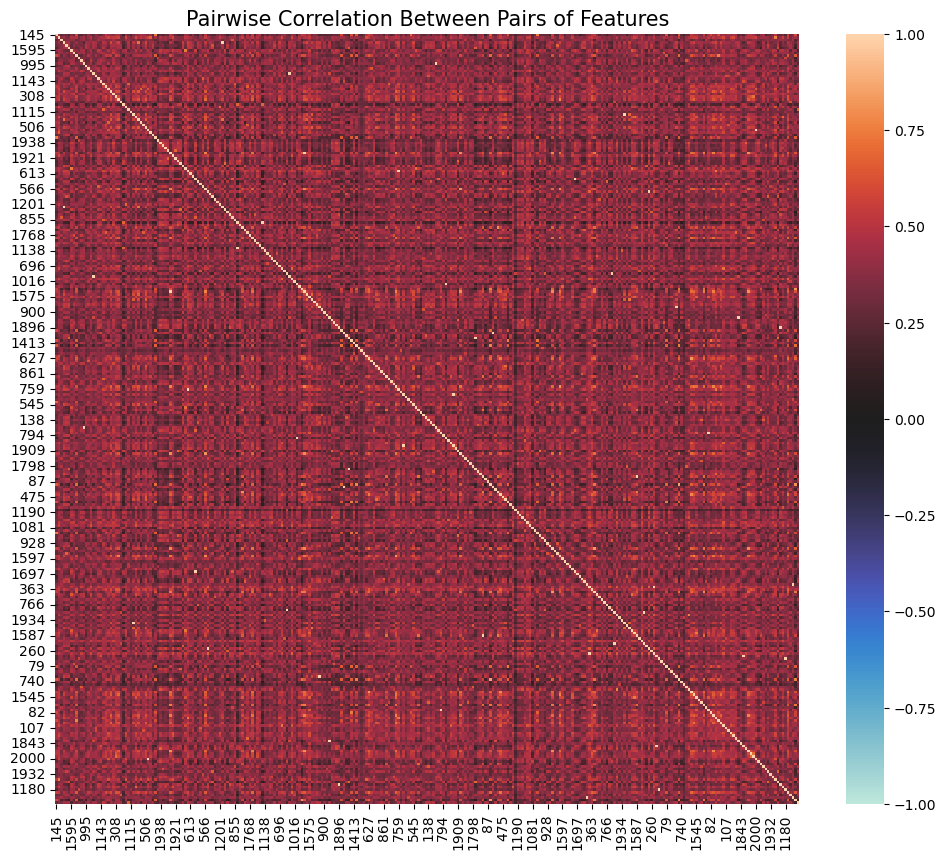

In [21]:
feature_corrs = pd.DataFrame(X_train).sample(300, axis=1).sample(500, axis=0).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(data = feature_corrs, annot=False, cmap = 'icefire', vmin=-1, vmax=1)
plt.title('Pairwise Correlation Between Pairs of Features');

# Low-Dimensional Embeddings of the Data

Variance explained by principal components: 0.5575


Variance explained by principal components: 0.6636


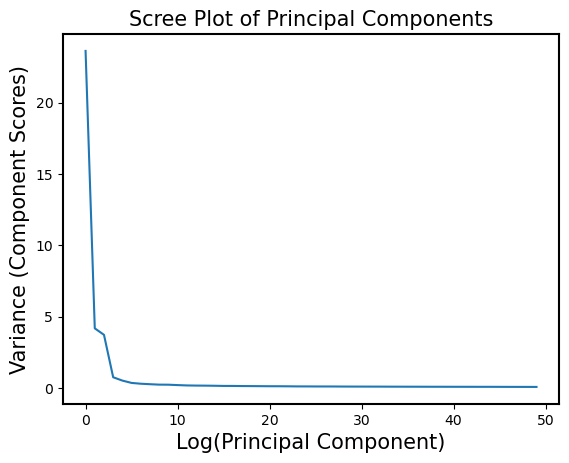

In [110]:
n_components = 50
pca = PCA(n_components=n_components)
pca.fit(X_train)
Z_pca = pca.transform(X_train)
print('Variance explained by principal components:', round(np.sum(pca.explained_variance_ratio_), 4))

X_mean = np.mean(X_train, axis = 0)
X_std = np.std(X_train, axis = 0)
X_standardized = (X_train - X_mean) / X_std
X_standardized[np.isinf(X_standardized)] = np.nan
X_standardized = np.nan_to_num(X_standardized)


s = pca.singular_values_
component_scores = np.zeros(len(s))
for i in range(len(s)):
    component_scores[i] = s[i]**2 / len(X_standardized)
ticks = 1 + np.arange(len(s))
sns.lineplot(component_scores)
# plt.xscale('log')
# plt.yscale('log')
plt.title(f'Scree Plot of Principal Components')
plt.xlabel('Log(Principal Component)')
plt.ylabel('Variance (Component Scores)');

(1280, 32)


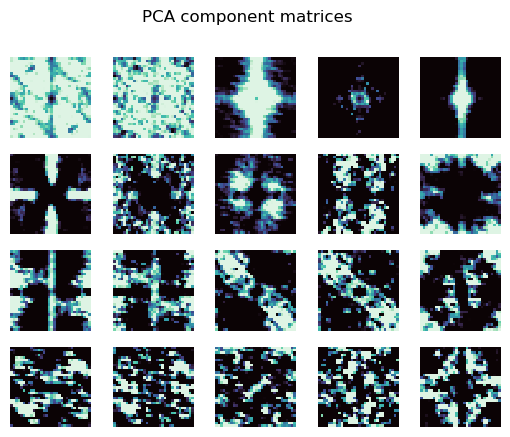

In [109]:
pca_mu = np.mean(pca.components_, axis=0)
pca_std = np.std(pca.components_, axis=0)
pca_standardized = (pca.components_.copy() - pca_mu) / pca_std
pca_standardized = np.nan_to_num(pca_standardized)

# pca_vis_shape = (len(pca_standardized), )
# pca_vis = pca_standardized.reshape(pca_vis_shape)
pca_vis = np.clip(255*pca_standardized, 0., 255.).astype(np.uint8)

nelems = pca_vis.shape[0] * pca_vis.shape[1]
cols = 32
new_rows = int(np.ceil(nelems / 32))

pca_vis = np.pad(pca_vis.ravel(), (0, cols*new_rows - nelems)).reshape((new_rows, cols))

print(pca_vis.shape)

# plt.figure(figsize=(10,10))
# plt.matshow(np.transpose(np.reshape(pca_vis, (len(pca_vis) * 32, 32)), (1, 0)))
r = max(n_components // 5, 2)
c = 5
fig, axs = plt.subplots(r, c)
for i in range(r):
    for j in range(c):
        ax = axs[i][j]
        idx = i*10 + j
        mat = pca_vis[idx*32: (idx+1)*32, :]
        ax.matshow(mat, cmap='mako')
        ax.axis('off')
# plt.matshow(pca_vis)

fig.suptitle('PCA component matrices');
plt.show()

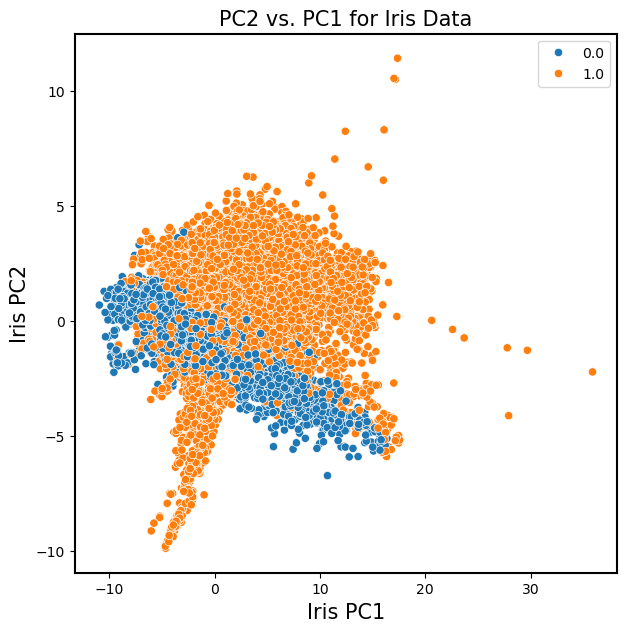

In [25]:
plt.figure(figsize = (7, 7))
plt.title("PC2 vs. PC1 for Iris Data")
plt.xlabel("Iris PC1")
plt.ylabel("Iris PC2")
sns.scatterplot(x = Z_pca[:, 0], y = Z_pca[:,1], hue = Y_train);

In [26]:
plt.rcParams["figure.facecolor"] = 'gray'
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=15).fit_transform(Z_pca)

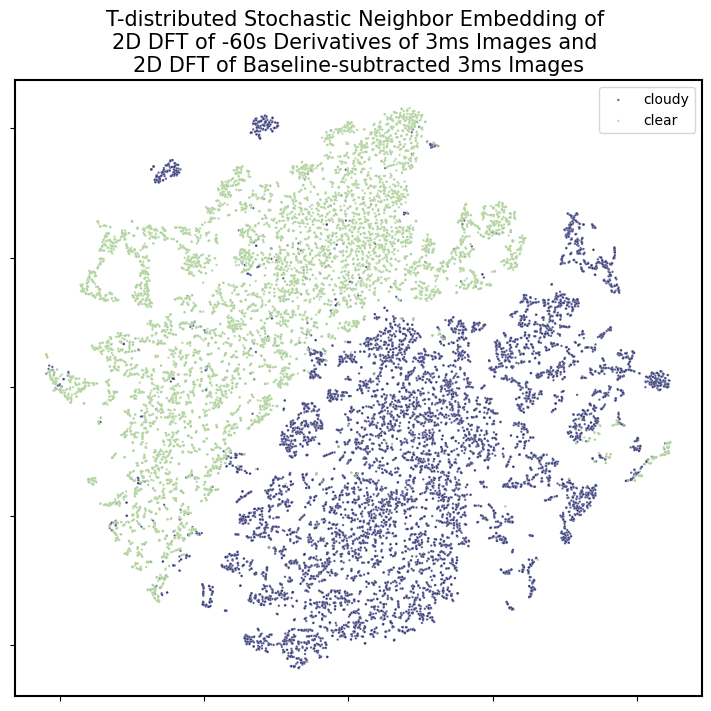

In [32]:
plt.rcParams["figure.facecolor"] = 'white'
def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    x_ones = x[points_color==1]
    y_ones = y[points_color==1]
    c_ones = points_color[points_color == 1]
    sns.scatterplot(x=x_ones, y=y_ones, c=c_ones, s=3, alpha=0.8, vmin=0, vmax=1, cmap='crest', ax=ax, label='cloudy')
    x_zero = x[points_color==0]
    y_zero = y[points_color==0]
    c_zero = points_color[points_color == 0]
    sns.scatterplot(x=x_zero, y=y_zero, c=c_zero, s=3, alpha=0.8, vmin=0, vmax=1, cmap='crest', ax=ax, label='clear')
    # ax.scatter(x, y, c=points_color, s=10, alpha=0.8, cmap='crest')
    ax.set_title(title)
    
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
    
    
def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)
    
    add_2d_scatter(ax, points, points_color)
    plt.title(title)
    plt.legend()
    plt.show()

plot_2d(X_embedded, 
        Y_train, 
        "T-distributed Stochastic Neighbor Embedding of \n2D DFT of -60s Derivatives of 3ms Images and \n2D DFT of Baseline-subtracted 3ms Images")


# Train a Logistic Regression Model

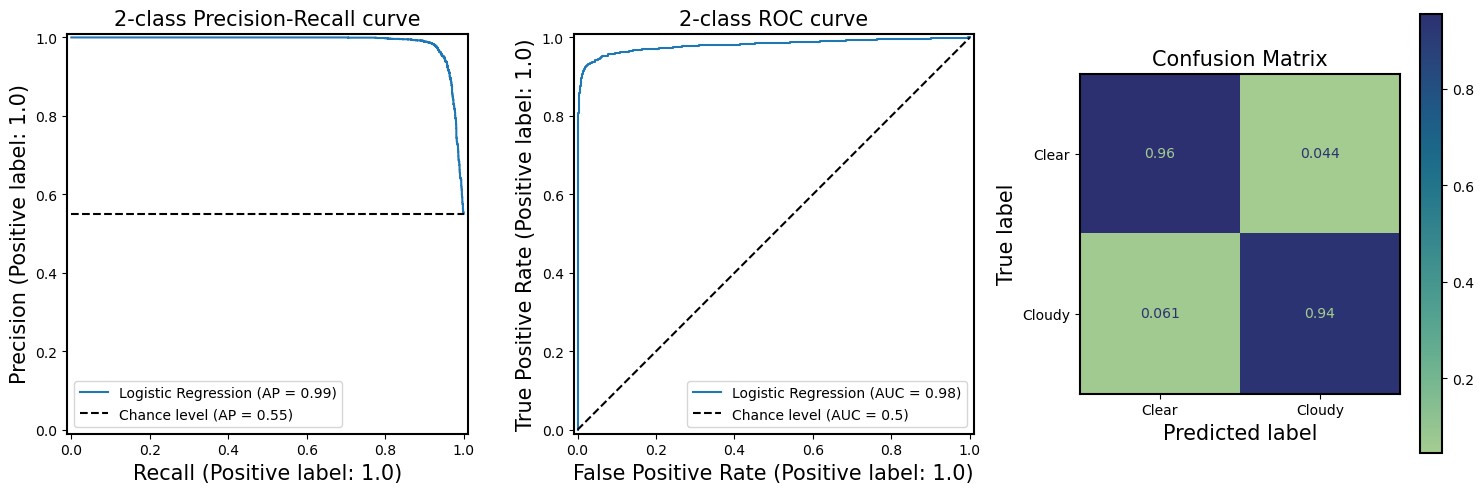

In [37]:
lr_model = make_pipeline(
    StandardScaler(), 
    PCA(n_components=3),
    LogisticRegression(
        # C=0.1,
        # class_weight={
        #     0: 1,
        #     1: 10
        # },
        # penalty='elasticnet',
        # solver='saga',
        # l1_ratio=0.05
    )
)
lr_model.fit(X_train, Y_train)

# plt.figure(figsize=(10,20))
f, axs = plt.subplots(1, 3, figsize=(15, 5))

pr_display = PrecisionRecallDisplay.from_estimator(
    lr_model, X_test, Y_test, name="Logistic Regression", plot_chance_level=True, ax=axs[0]
)
axs[0].set_title("2-class Precision-Recall curve")


roc_display = RocCurveDisplay.from_estimator(
    lr_model, X_test, Y_test, name="Logistic Regression", plot_chance_level=True, ax=axs[1]
)
axs[1].set_title("2-class ROC curve")

confusion_matrix_display = ConfusionMatrixDisplay.from_estimator(
    lr_model, 
    X_test, 
    Y_test, 
    ax=axs[2], 
    display_labels = ['Clear', 'Cloudy'], 
    normalize='true', 
    cmap='crest'
)
axs[2].set_title("Confusion Matrix");
plt.tight_layout()